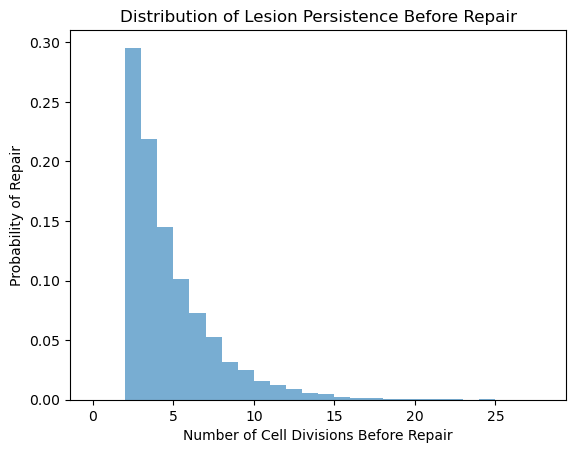

Mean persistence: 4.33
Variance of persistence: 7.79


In [22]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_DNA_lesion_persistence(p, n_simulations=1000):
    persistence_duration = [] #Initialises an empty list to store the number of divisions before repair occurs in each simulation.
    
    for _ in range(n_simulations): #Loops n_simulations times to run that many independent experiments
        divisions = 1   #this assumes the lesion already survived one division 
        while True:
            divisions += 1 #adds one more division 
            if np.random.rand() < p: #Check for repair (Bernoulli trial)
                break
        persistence_duration.append(divisions) #Adds the total number of divisions the lesion persisted (before repair) to the results list.
    
    return persistence_duration #Returns the full list of division counts from all simulations.

# Example usage:
p = 0.3  # Repair probability
results = simulate_DNA_lesion_persistence(p, 10000)

# Plot
plt.hist(results, bins=range(0, max(results)+1), density=True, alpha=0.6)
plt.title("Distribution of Lesion Persistence Before Repair")
plt.xlabel("Number of Cell Divisions Before Repair")
plt.ylabel("Probability of Repair")
plt.show()

# Compute statistics
mean_persistence = np.mean(results)
variance_persistence = np.var(results)

print(f"Mean persistence: {mean_persistence:.2f}")
print(f"Variance of persistence: {variance_persistence:.2f}")


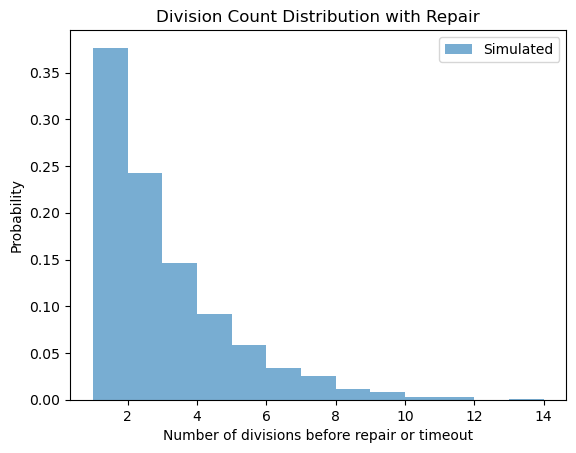

Mean number of divisions: 2.57
Variance: 3.54


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

rng = np.random.default_rng()

# Parameters
nTrials = 5000
mitRate = 0.5 # division rate (λ)
T= 10          # end time
rho = 0.3      # repair rate

# Exponential-based repair probability 
def repair_probability(rho, deltaT):
    return 1 - np.exp(-rho * deltaT)

# experiment: track divisions until repair or end time
def experiment_with_repair(mitRate, T, rho):
    t = 0
    nDivisions = 1
    
    while True:
        deltaT = rng.exponential(1 / mitRate)
        t += deltaT #t+divisiontime
        
        if t > T:
            break  # end of time reached (stop limit exceeds)
        
        # Check for repair (Bernoulli trial)
        if rng.uniform() < repair_probability(rho, deltaT): #Generates a random number between 0 and 1, “With this probability, the repair occurs.”
            
            break
        
        nDivisions += 1  # no repair, continue
    
    return nDivisions

# Run trials
experimentResults = [experiment_with_repair(mitRate, T, rho) for _ in range(nTrials)] #Repeat the division + repair process nTrials times. 

# Plot histogram
plt.hist(experimentResults, bins=range(1, max(experimentResults)+1), density=True, alpha=0.6, label='Simulated')


plt.xlabel("Number of divisions before repair or timeout")
plt.ylabel("Probability")
plt.title("Division Count Distribution with Repair")
plt.legend()
plt.show()

mean_divs = np.mean(experimentResults)
var_divs = np.var(experimentResults)
print(f"Mean number of divisions: {mean_divs:.2f}")
print(f"Variance: {var_divs:.2f}")


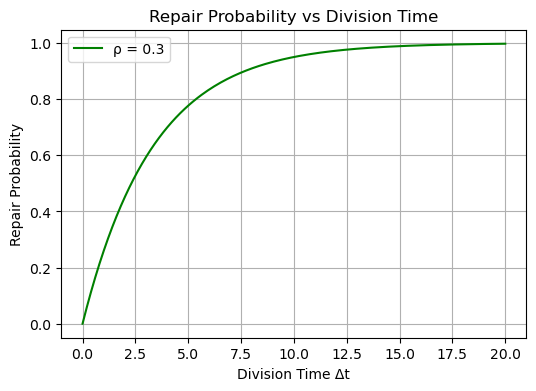

In [6]:
# Time range (possible division times)
deltaT_range = np.linspace(0, 20, 200)

# Corresponding repair probabilities
repair_probs = [repair_probability(rho, deltaT) for deltaT in deltaT_range]

plt.figure(figsize=(6, 4))
plt.plot(deltaT_range, repair_probs, label=f'ρ = {rho}', color='green')
plt.xlabel("Division Time Δt")
plt.ylabel("Repair Probability")
plt.title("Repair Probability vs Division Time")
plt.grid(True)
plt.legend()
plt.show()


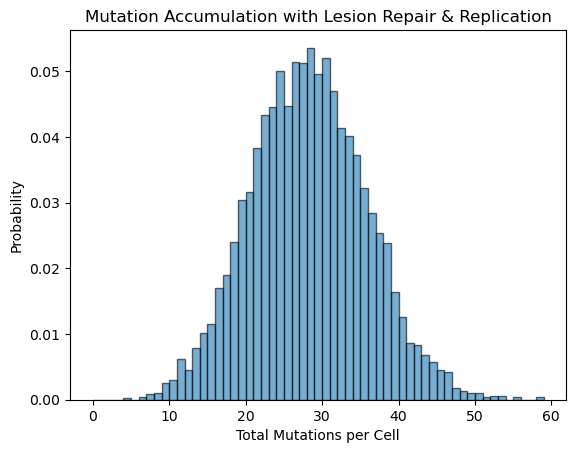

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Random generator
rng = np.random.default_rng()

# Parameters
nTrials = 5000
mitRate = 0.5         # Division rate (λ)
T = 50                # end time
lesionRate = 2.0      # Lesions per unit time
rho = 0.3             # Repair rate (per time step)

def simulate_cell(mitRate, T, lesionRate, rho):
    t = 0
    mutations = 0
    totallesion = 0  # Lesions carried over from previous cycles

    while t < T:
        # Time to next division (cell cycle length)
        deltaT = rng.exponential(1 / mitRate)
        t += deltaT
        
        if t > T:
            break  # end time reached

        # 1: Lesion accumulation & repair before replication ---
        # New lesions arise during this cell cycle (Poisson process)
        new_lesions = rng.poisson(lesionRate * deltaT)
        totallesion += new_lesions

        # Repair existing lesions (each has probability 1 - e^(-rho * deltaT) to be repaired)
        # (Exponential repair process)
        repaired_lesions = rng.binomial(totallesion, 1 - np.exp(-rho * deltaT))
        totallesion -= repaired_lesions

        # 2: Genome replication (50/50 chance for lesions to become mutations) ---
        # For each remaining lesion, flip a coin:
        # 50% chance: becomes a mutation (removed from totallesion)
        # 50% chance: remains a lesion (carried to next cycle)
        lesions_becoming_mutations = rng.binomial(totallesion, 0.5)
        mutations += lesions_becoming_mutations
        totallesion -= lesions_becoming_mutations

    return mutations

# Run simulation across many trials
mutation_counts = [simulate_cell(mitRate, T, lesionRate, rho) for _ in range(nTrials)]

# Plot histogram
plt.hist(mutation_counts, bins=range(0, max(mutation_counts) + 1), density=True, alpha=0.6, edgecolor='black')
plt.xlabel("Total Mutations per Cell")
plt.ylabel("Probability")
plt.title("Mutation Accumulation with Lesion Repair & Replication")
plt.show()

Model A (fixed ΔT = 1/mitRate, per-division Bernoulli):
  Mean     = 1.174000
  Variance = 2.106524

Model B (Continuous, Exp interdivision times, time cap T):
  Mean     = 1.595600
  Variance = 3.655261


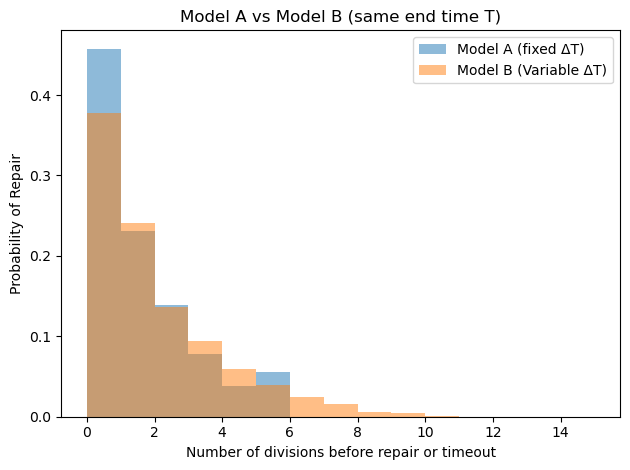

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp


nTrials = 5000   # number of simulated cells
mitRate = 0.5   # division rate (λ)
T = 10.0         # end time 
rho = 0.3        # repair rate


rng = np.random.default_rng()  # no seed → different results each run

# Model A fixed ΔT
def modelA_counts(nTrials, mitRate, T, rho, rng):
    dT = 1.0 / mitRate #Fixed interdivision time ΔT = 1/mitRate (no variability).
    p = 1.0 - exp(-rho * dT) #Per-division repair probability: p = 1 - exp(-rho * ΔT)
    Nmax = int(T // dT) #Count = divisions BEFORE repair (or Nmax if no repair within T)

    results = []
    for _ in range(nTrials):
        nDivisions = 0  # divisions before repair
        for _ in range(Nmax):
            if rng.random() < p:
                break
            nDivisions += 1
        results.append(nDivisions)
    return np.array(results)

#Model B (Variable ΔT)
def modelB_counts(nTrials, mitRate, T, rho, rng):
    results = np.empty(nTrials, dtype=int)
    for i in range(nTrials):
        t = 0.0
        nDivisions = 0
        while True:
            dt = rng.exponential(1.0 / mitRate)
            if rng.random() < (1.0 - np.exp(-rho * dt)): # Interdivision gaps ~ Exp(mitRate); repair in gap with prob 1 - exp(-rho*dt).
                results[i] = nDivisions
                break
            t += dt
            if t > T:
                results[i] = nDivisions
                break
            nDivisions += 1
    return results

# Run both models 
mA = modelA_counts(nTrials, mitRate, T, rho, rng)
mB = modelB_counts(nTrials, mitRate, T, rho, rng)

#Print mean & variance
print("Model A (fixed ΔT = 1/mitRate, per-division Bernoulli):")
print(f"  Mean     = {np.mean(mA):.6f}")
print(f"  Variance = {np.var(mA):.6f}")

print("\nModel B (Continuous, Exp interdivision times, time cap T):")
print(f"  Mean     = {np.mean(mB):.6f}")
print(f"  Variance = {np.var(mB):.6f}")

#Histogram (overlay)
bins = np.arange(min(mA.min(), mB.min()), max(mA.max(), mB.max()) + 2)
plt.hist(mA, bins=bins, density=True, alpha=0.5, label='Model A (fixed ΔT)')
plt.hist(mB, bins=bins, density=True, alpha=0.5, label='Model B (Variable ΔT)')
plt.xlabel("Number of divisions before repair or timeout")
plt.ylabel("Probability of Repair")
plt.title("Model A vs Model B (same end time T)")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
## Remove T from the model and recoded in a simpler way

Model A (fixed ΔT, per-division Bernoulli):
  Mean     = 1.209800
  Variance = 2.662984

Model B (Continuous, Exp interdivision times):
  Mean     = 1.684000
  Variance = 4.680544


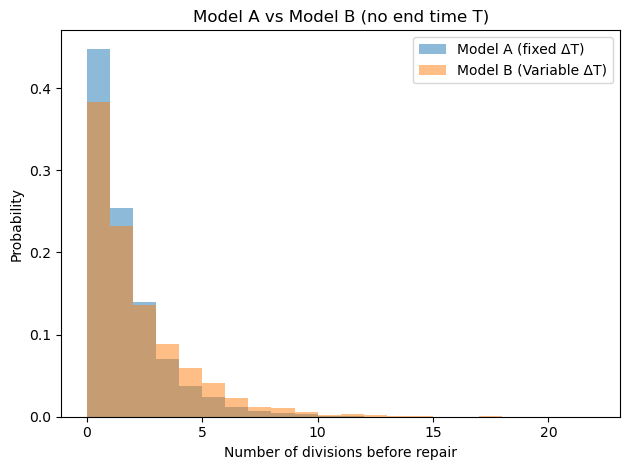

In [12]:
import random
import statistics
from math import exp
import matplotlib.pyplot as plt

nTrials = 5000   # number of simulated cells
mitRate = 0.5    # division rate (λ)
rho = 0.3        # repair rate

# Model A (fixed ΔT)
def modelA_counts(nTrials, mitRate, rho):
    dT = 1.0 / mitRate  # Fixed interdivision time
    p = 1.0 - exp(-rho * dT)  # Per-division repair probability

    results = []
    for _ in range(nTrials):
        nDivisions = 0
        while True:
            if random.random() < p:  # repair happens
                break
            nDivisions += 1
        results.append(nDivisions)
    return results

# Model B (Variable ΔT)
def modelB_counts(nTrials, mitRate, rho):
    results = []
    for _ in range(nTrials):
        nDivisions = 0
        while True:
            dt = random.expovariate(mitRate)  # interdivision gap
            if random.random() < (1.0 - exp(-rho * dt)):  # repair in this gap
                break
            nDivisions += 1
        results.append(nDivisions)
    return results

# Run both models
mA = modelA_counts(nTrials, mitRate, rho)
mB = modelB_counts(nTrials, mitRate, rho)

# Print mean & variance
print("Model A (fixed ΔT, per-division Bernoulli):")
print(f"  Mean     = {statistics.mean(mA):.6f}")
print(f"  Variance = {statistics.pvariance(mA):.6f}")

print("\nModel B (Continuous, Exp interdivision times):")
print(f"  Mean     = {statistics.mean(mB):.6f}")
print(f"  Variance = {statistics.pvariance(mB):.6f}")

# Histogram (overlay)
bins = range(min(min(mA), min(mB)), max(max(mA), max(mB)) + 2)
plt.hist(mA, bins=bins, density=True, alpha=0.5, label='Model A (fixed ΔT)')
plt.hist(mB, bins=bins, density=True, alpha=0.5, label='Model B (Variable ΔT)')
plt.xlabel("Number of divisions before repair")
plt.ylabel("Probability")
plt.title("Model A vs Model B (no end time T)")
plt.legend()
plt.tight_layout()
plt.show()


Model A (fixed ΔT, per-division Bernoulli):
  Mean     = 1.197400
  Variance = 2.607633

Model B (Continuous, Exp interdivision times):
  Mean     = 1.651200
  Variance = 4.446739


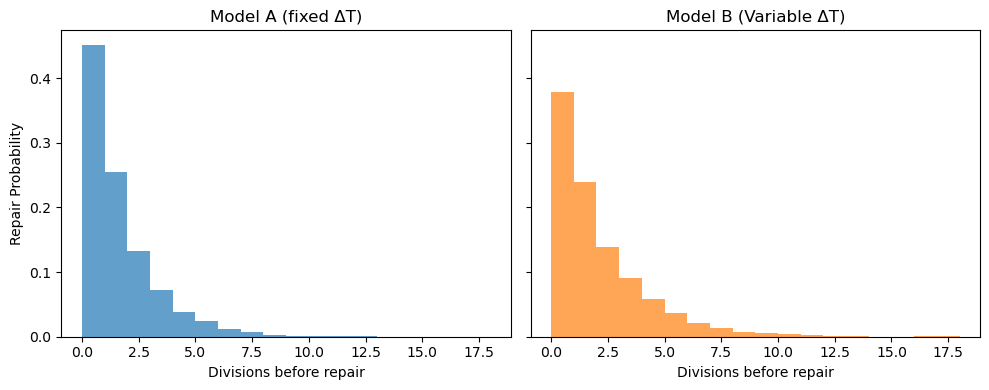

In [10]:
import random
import statistics
from math import exp
import matplotlib.pyplot as plt

nTrials = 5000   # number of simulated cells
mitRate = 0.5    # division rate (λ)
rho = 0.3        # repair rate

# Model A (fixed ΔT)
def modelA_counts(nTrials, mitRate, rho):
    dT = 1.0 / mitRate  # Fixed interdivision time
    p = 1.0 - exp(-rho * dT)  # Per-division repair probability

    results = []
    for _ in range(nTrials):
        nDivisions = 0
        while True:
            if random.random() < p:  # repair happens
                break
            nDivisions += 1
        results.append(nDivisions)
    return results

# Model B (Variable ΔT)  
def modelB_counts(nTrials, mitRate, rho):
    results = []
    for _ in range(nTrials):
        nDivisions = 0
        while True:
            dt = random.expovariate(mitRate)  # interdivision gap
            if random.random() < (1.0 - exp(-rho * dt)):  # repair in this gap
                break
            nDivisions += 1
        results.append(nDivisions)
    return results

# Run both models
mA = modelA_counts(nTrials, mitRate, rho)
mB = modelB_counts(nTrials, mitRate, rho)

# Print mean & variance
print("Model A (fixed ΔT, per-division Bernoulli):")
print(f"  Mean     = {statistics.mean(mA):.6f}")
print(f"  Variance = {statistics.pvariance(mA):.6f}")

print("\nModel B (Continuous, Exp interdivision times):")
print(f"  Mean     = {statistics.mean(mB):.6f}")
print(f"  Variance = {statistics.pvariance(mB):.6f}")

# Side-by-side histograms
bins = range(min(min(mA), min(mB)), max(max(mA), max(mB)) + 2)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].hist(mA, bins=bins, density=True, alpha=0.7, color='tab:blue')
axes[0].set_title("Model A (fixed ΔT)")
axes[0].set_xlabel("Divisions before repair")
axes[0].set_ylabel("Repair Probability")

axes[1].hist(mB, bins=bins, density=True, alpha=0.7, color='tab:orange')
axes[1].set_title("Model B (Variable ΔT)")
axes[1].set_xlabel("Divisions before repair")

plt.tight_layout()
plt.show()


Slope (mutations/year) ≈ 17.24


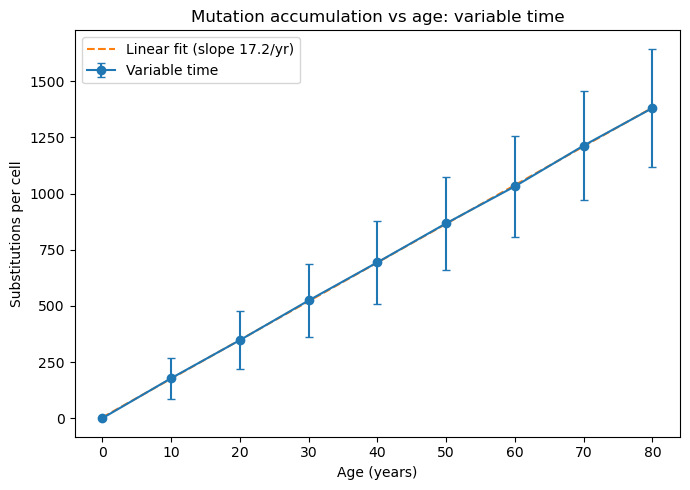

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Random generator
rng = np.random.default_rng()

# Parameters
nTrials    = 5000
mitRate    = 1.0        # Divisions per year
lesionRate = 480        # Lesions per year (tune to match slope ~17.0/yr)
rho        = 3.0        # Repair rate per year (tune)
ages       = [0, 10, 20, 30, 40, 50, 60, 70, 80]  # Years

def simulate_cell(mitRate, T, lesionRate, rho):
    t = 0
    mutations = 0
    totallesion = 0  # Lesions carried over from previous cycles

    while t < T:
        # Time to next division (cell cycle length)
        deltaT = rng.exponential(1 / mitRate)
        t += deltaT
        if t > T:
            break  # end time reached

        # Lesion accumulation
        new_lesions = rng.poisson(lesionRate * deltaT)
        totallesion += new_lesions

        # Repair
        repaired_lesions = rng.binomial(totallesion, 1 - np.exp(-rho * deltaT))
        totallesion -= repaired_lesions

        # Replication: half of remaining lesions become mutations
        lesions_becoming_mutations = rng.binomial(totallesion, 0.5)
        mutations += lesions_becoming_mutations
        totallesion -= lesions_becoming_mutations

    return mutations

# ---- Run simulation across ages ----
means, stds = [], []
for T in ages:
    mutation_counts = [simulate_cell(mitRate, T, lesionRate, rho) for _ in range(nTrials)]
    means.append(np.mean(mutation_counts))
    stds.append(np.std(mutation_counts, ddof=1))

# ---- Linear regression fit ----
coef = np.polyfit(ages, means, 1)   # slope and intercept
fit_line = np.polyval(coef, ages)
print(f"Slope (mutations/year) ≈ {coef[0]:.2f}")

# ---- Plot ----
plt.figure(figsize=(7,5))

# Lesion-repair model
plt.errorbar(ages, means, yerr=stds, fmt='o-', capsize=3, label="Variable time")

# Linear regression fit
plt.plot(ages, fit_line, '--', label=f"Linear fit (slope {coef[0]:.1f}/yr)")

plt.xlabel("Age (years)")
plt.ylabel("Substitutions per cell")
plt.title("Mutation accumulation vs age: variable time")
plt.legend()
plt.tight_layout()
plt.show()


Slope (mutations/year) ≈ 17.36


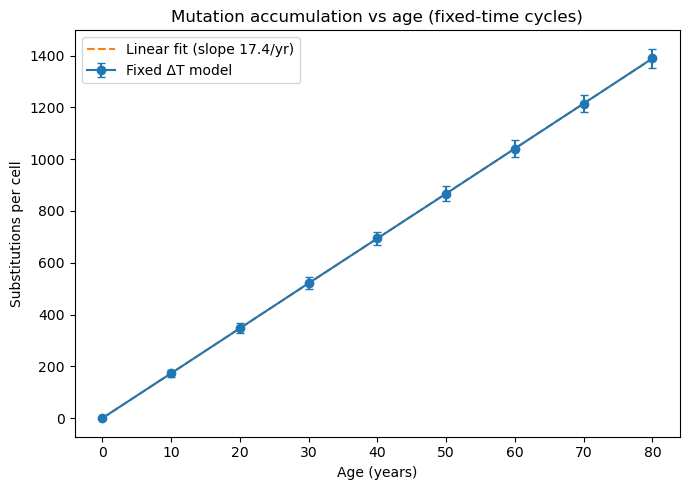

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Random generator
rng = np.random.default_rng()

# Parameters
nTrials    = 5000
mitRate    = 1.0        # Divisions per year
lesionRate = 680        # Lesions per year (tune to match slope ~17/yr)
rho        = 3.0        # Repair rate per year (tune)
ages       = [0, 10, 20, 30, 40, 50, 60, 70, 80]  # Years

def simulate_cell_fixed(mitRate, T, lesionRate, rho):
    t = 0.0
    mutations = 0
    totallesion = 0  # lesions carried over between cycles
    deltaT = 1.0 / mitRate  # fixed cycle length

    while t < T:
        t += deltaT
        if t > T:
            break  # end time reached

        # Lesion accumulation during this cycle
        new_lesions = rng.poisson(lesionRate * deltaT)
        totallesion += new_lesions

        # Repair during this cycle
        repaired_lesions = rng.binomial(totallesion, 1 - np.exp(-rho * deltaT))
        totallesion -= repaired_lesions

        # Replication: 50% of remaining lesions become fixed mutations
        lesions_becoming_mutations = rng.binomial(totallesion, 0.5)
        mutations += lesions_becoming_mutations
        totallesion -= lesions_becoming_mutations

    return mutations

# ---- Run simulation across ages ----
means, stds = [], []
for T in ages:
    mutation_counts = [simulate_cell_fixed(mitRate, T, lesionRate, rho) for _ in range(nTrials)]
    means.append(np.mean(mutation_counts))
    stds.append(np.std(mutation_counts, ddof=1))

# ---- Linear regression fit ----
coef = np.polyfit(ages, means, 1)   # slope and intercept
fit_line = np.polyval(coef, ages)
print(f"Slope (mutations/year) ≈ {coef[0]:.2f}")

# ---- Plot mean ± error bars with regression ----
plt.figure(figsize=(7,5))
plt.errorbar(ages, means, yerr=stds, fmt='o-', capsize=3, label="Fixed ΔT model")
plt.plot(ages, fit_line, '--', label=f"Linear fit (slope {coef[0]:.1f}/yr)")

plt.xlabel("Age (years)")
plt.ylabel("Substitutions per cell")
plt.title("Mutation accumulation vs age (fixed-time cycles)")
plt.legend()
plt.tight_layout()
plt.show()
